# Saurabh Bhattarai
# BHA22597750

Link to notebook on colab: https://colab.research.google.com/drive/111eaEBeaLxnwVoD1LrgBqRTVWWGsPOAd?usp=sharing

Link to dataset on colab: https://drive.google.com/drive/folders/1D-iOcIzdGzo6Ef6eHTtdF8gyfp61rncJ?usp=sharing

# Facial Expression Recognition (FER)
**OVERVIEW:**
  The model in this notebook are designed using Convolutional Neural Network (CNN) which consists of several convolutional, pooling and classifier layer. ReLU() activation function is used in between layers and a softmax() is used to convert the logits into probabilities. PyTorch framework is used in order to enhance the efficiency and simplicity of execution.



  A light version of AffectNet dataset is used to train the model, which is an open dataset available in kaggle. (The original AffectNet dataset consists of 0.4 million images, which is a huge dataset beyond the scope of the study.) The dataset consists of around 29000 RGB images reduced down to 96 by 96 pixels.

  

  Dataset link: https://www.kaggle.com/datasets/noamsegal/affectnet-training-data

# 1. Setup device agnostic code

In [ ]:
import torch

# Check the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Check the device that the code is running on
print(device)

cuda


# 2. Mount the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The images are distributed into 8 different folders (the folders name are misleading as they seems to represent eight major expressions). However, the folder name are not the actual label for each images. The labels are found on a different csv file inside the dataset main folder named 'labels.csv'. The file consists of 4 columns. Nevertheless, we are only intrested in two of them:

1. 'pth'-
This column gives the folder name and image name in this format -> 'folder_name/image_name'

2. 'label'-
This column gives the acual label of the image.

Looking the following code and it's return, it is more clear.

In [ ]:
import pandas as pd

# Import the 'labels' file and check what is inside....
labels = pd.read_csv('/content/drive/MyDrive/DL AffectNet/labels.csv')
labels.head()

Unnamed: 0                     pth     label    relFCs
0           0  anger/image0000006.jpg  surprise  0.873142
1           1  anger/image0000060.jpg     anger  0.852311
2           2  anger/image0000061.jpg     anger  0.800957
3           3  anger/image0000066.jpg   disgust  0.843079
4           4  anger/image0000106.jpg     anger  0.849108

In [ ]:
# # Uncomment this cell, this will randomly select 'N' number of samples images
# N = 1000
# random_sample = labels.sample(n=N)
# random_sample.reset_index(drop=True, inplace=True)
# labels = random_sample

# 3.1 Import the data

In [ ]:
# Import necessary libraries
import os
from tqdm.auto import tqdm
from PIL import Image
import torch
from torchvision import transforms

# Defining tensor transformation
transform = transforms.ToTensor()

# Set the initial data and label list
data=[]
data_labels=[]

print('Total images is 28175')

# Looping through each row in the 'labels' file and utilizing the 'pth' column to define each individual image directory
for index, row in tqdm(labels.iterrows()):

  # Splitting the folder name and image name
  folder_name,image_name = row['pth'].split('/')

  # Joining the main dataset folder path in google drive, the folder name and each image name
  image_path = os.path.join('/content/drive/MyDrive/DL AffectNet', folder_name,image_name)

  # Using the joined image path and opening the image
  image=Image.open(image_path)

  # Transforming the image into tensors
  image=transform(image)

  # Adding the transformed tensor image in the data
  data.append(image)

Total images is 28175


0it [00:00, ?it/s]

# 3.2. Label Consistency

Checking and indexing the labels and creating a dictionary of label indexes and labels

In [ ]:
# Getting the each labels
unique_classes = labels['label'].unique()

# Set up index for each labels
class_to_index= {class_name: index for index, class_name in enumerate(unique_classes)}

# Mapping the label and index
labels['class_index'] = labels['label'].map(class_to_index)

In [ ]:
# Check all the labels
unique_classes

array(['surprise', 'anger', 'disgust', 'fear', 'sad', 'contempt',
       'neutral', 'happy'], dtype=object)

In [ ]:
# Checing the label and label index
class_to_index

{'surprise': 0,
 'anger': 1,
 'disgust': 2,
 'fear': 3,
 'sad': 4,
 'contempt': 5,
 'neutral': 6,
 'happy': 7}

Checking the number of images in each classes

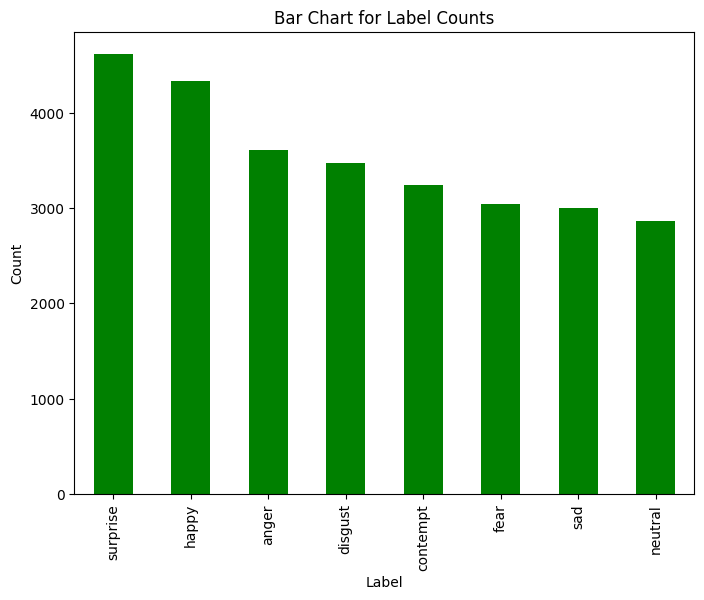

In [ ]:
# Counting the number of images in each labels
label_counts = labels['label'].value_counts()

# Plotting and comparing the label counts of each labels
import matplotlib.pyplot as plt

# Defining the figure size
plt.figure(figsize=(8, 6))

# Plotting a green vertical bar chart
label_counts.plot(kind='bar', color='green')

# Giving X and Y lablels
plt.xlabel('Label')
plt.ylabel('Count')
# Title

plt.title('Bar Chart for Label Counts')
plt.show()

Importing the labels in the order of imported data (images) and assinging the index as defined in the above section.

In [ ]:
data_labels=[]
data_label_index=[]

# Looping through the each row in the 'labels' file and adding each label to a list (similar to importing the image)
for index, row in tqdm(labels.iterrows()):

  # Adding each label in 'data_labels' list
  data_labels.append(row['label'])

  # Adding corresponding labels index in the same order
  data_label_index.append(row['class_index'])

0it [00:00, ?it/s]

In [ ]:
# Checking the length of data and labels to ensure consistency
len(data), len(data_labels), len(data_label_index)

(28175, 28175, 28175)

Merging the image data and the label index. This is an important step. Instead of merging the actual labels, the labels are mapped to their corresponding index. This is done because the labels are string and PyTorch neural network execution doesn't support string. However, mapping each label to index and passing through the neural network is the simplest and effective solution for this.

In [ ]:
# First, transforming the index to tensors
data_label_index_tensor = torch.tensor(data_label_index)

# Merging the image data and image data label index
data_with_labels = list(zip(data, data_label_index_tensor))

In [ ]:
# Check the input shape of the data
image, idx=data_with_labels[7]
image.shape, idx.shape

(torch.Size([3, 96, 96]), torch.Size([]))

# 4. Split the data in train and test

In [ ]:
# Importing train_test_split from scikit-learn library
from sklearn.model_selection import train_test_split

# Splittin 80% of the data into training set and remaining 20% to testing set
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    data_label_index_tensor,
                                                    test_size=0.2,
                                                    random_state=42)


In [ ]:
# Sending the data  and labels to the current device to avoid device mismatch error
X_train = [tensor.to(device) for tensor in X_train]
y_train = [tensor.to(device) for tensor in y_train]
X_test = [tensor.to(device) for tensor in X_test]
y_test = [tensor.to(device) for tensor in y_test]

In [ ]:
# Checking out the length of train and test sets
print(f'The number of training data is {len(X_train)} and training labels is {len(y_train)}')
print(f'The number of testing data is {len(X_test)} and testing labels is {len(y_test)}')

The number of training data is 22540 and training labels is 22540
The number of testing data is 5635 and testing labels is 5635


# 5. Visualizing the data and checking what's inside

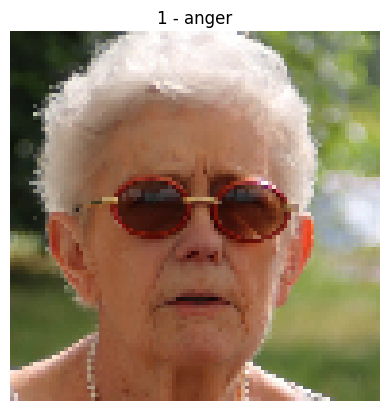

17753


In [ ]:
# Get a random integer
random_number=torch.randint(1,len(data),size=(1,)).item()

# Getting the data and label corresponding to that random integer
image, class_index = data_with_labels[random_number]

# Plot the image using matplotlib library
import matplotlib.pyplot as plt
plt.imshow(image.permute(1,2,0))
plt.axis(False)
plt.title(f'{class_index} - {unique_classes[class_index]}')
plt.show()
print(random_number)

Plot more images

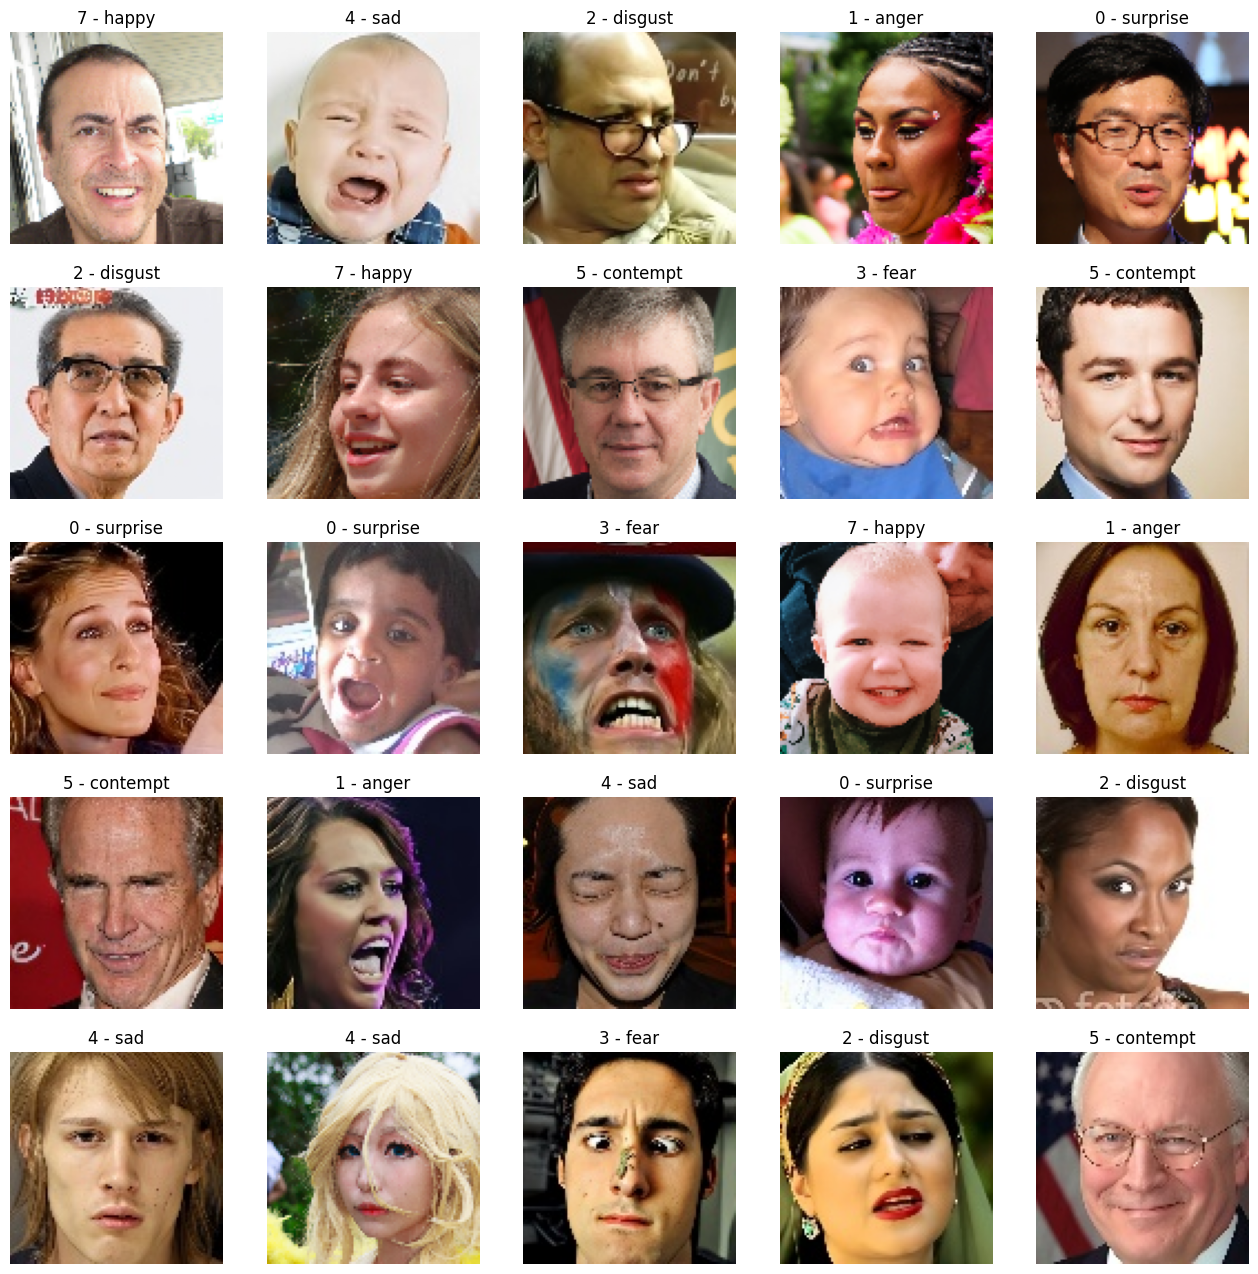

In [ ]:
# Plotting 16 more random images

# Defining the figure
fig = plt.figure(figsize=(16,16))

# Defining the number of rows and columns of the image
rows,cols=5,5

# Running a loop
for i in range(1, rows*cols+1):

  # Getting random integers
  random_idx = torch.randint(0,len(data), size=[1]).item()

  # Getting the image
  img, class_index= data_with_labels[random_idx]

  # Defining where the image should be plotted
  fig.add_subplot(rows,cols,i)

  # Plotting the images along with their labels and index
  plt.imshow(img.permute(1,2,0))
  plt.title(f'{class_index} - {unique_classes[class_index]}')
  plt.axis(False)
plt.show()

# 6. Preparing the dataloader

## 6.1. Why dataloader?
When training a whole dataset, the data are trained in a single go. However, dataloader is used here to split the data into different batches so model get trained by one batch at a time. This is benificial in several way which includer Memory Efficiency, Computational Efficiency, Generalization, etc.

Merging the images and their corresponding labels in both training and testing sets

In [ ]:
# Merge the data and labels to assign in the data loader
train_data = list(zip(X_train,y_train))
test_data = list(zip(X_test,y_test))

Defining the train and test data loaders

In [ ]:
from torch.utils.data import DataLoader

# Set up the batch size (HYPERPARAMETER)
BATCH_SIZE = 20

# Turn datasets into batches (iterables)
train_data_loader = DataLoader(dataset=train_data,
                         batch_size=BATCH_SIZE,
                         shuffle=True)
test_data_loader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

In [ ]:
# Looking at the number of batches in our training and testing sets
print(f'The total batches in our train dataloader is now {len(train_data_loader)}')
print(f'The total batches in our test dataloader is now {len(test_data_loader)}')

The total batches in our train dataloader is now 1127
The total batches in our test dataloader is now 282


In [ ]:
# Checking out the shape of train data loader
features_batch, label_batch = next(iter(train_data_loader))
features_batch.shape, label_batch.shape

(torch.Size([20, 3, 96, 96]), torch.Size([20]))

# 7. Create a time function

Creating a time function to find out how long it take to run the train test loop

In [ ]:
# Importing default_timer as timer function
from timeit import default_timer as timer

# Creating the time function
def print_time(start: float,
               end: float,
               device:torch.device=None):

  # Print the difference between start time and end time
  total_time= end-start
  print(f'Time on {device}: {total_time:.4f} seconds')

  # Return the total time taken from start to end
  return total_time

# 8. Building a Convolutional Neural Network

In this section, CNN models will be created and then the the evaluation results such as accuracy, loss, time taken to train the model, etc. of the models will be compared.

Apart from that, multiple HYPERPARAMETERS are taken into consideration to adjust so as to get the best performance from the model. The HYPERPARAMETERS includes:


1. Number of Convolutional Layers: Determines the depth of the network.

2. Filter Size/Kernel Size: This is the size of the filters (or kernels) used.

3. Stride: The number of pixels by which the filter is shifted over the image or matrix.

4. Padding: The number of layers around the matrix added or edges to preserve the actual data.

5. Pooling : Determines how much to downsample the feature map. E.g. Maxpooling, Avgpooling, etc.

6. Pooling Size: The size of the pooling window.

7. Activation Function: The non-linear activation function applied after each convolutional layer.

8. Learning Rate: Deternmines how much step size to take per iteration while moving towards minimum of loss_function.

9. Optimizer: Which optimizing algorithm to use to minimize the loss function.

10. Batch Size: The number of image sample used in one forward pass.

11. Number of Epochs: The number of times the whole dataset is passed through the model.

## 8.1. Why CNN

1. **Hierarchical Features:** CNNs are designed to capture geometric hierarchical features of images. For instance, human faces consists of complex spatial structures such as eyes, lips, nose, etc. CNNs can get the features, which is extrenly important for facial expression recognition
2. **Data-efficient:** CNNs can be trained from relatively small datasets.The ability of CNN to generalize in small data makes it suitable.
3. **Extracting Locally:** A filter runs across the image in convolutional layers in CNNs, which extracts the local patterns and features, which is advantageous for this problem. For example, CNN can recognize the raised eyebrows as 'surprise', or smily lips as 'happy'.
4. **Learn from raw inputs:** CNNs can be trained directly by feeding the data and labels. For instance in this case, mapping raw images to expression labels without any feature extraction.
5. **Deformation an& shift invariance:** The imput images can vary widely due to chanes in position, scale, illumination, etc. Regardless of these all variances, CNN have the ability to learn features

# 8.2. Build a CNN model: 'TinyVGG'

The TinyVGG refers to as the smaller version of VGG (Visual Geometry Group) neural network architecture.

The model architecture is explained below:

1. **Convolutional layers:**
* First, the RGB images with 3 channels is passed through a convolutional layer with 3 input and 32 output channels. The padding preserves the spatial dimensions when a 3 by 3 kernal is appilied through it.
* After that, in order to add non-linearity as spice, a ReLU() activation function is applied.
* Then, a max-pooling layer is applied in the feature map. This layer has a 2x2 kernal and stride=2. This layer downsample the feature maps by a factor of 2, that helps in learning hierarchical features and reducing computation.
* Following this, another Conv2d (convolutional) layer is added containing output channels of 64. Similar to before, padding is applied when kernal runs through the image.
* Again, relu activation function is applied.
* A max pool layer as before was applied again with same parameters.

2. **Fully Connected Layers (classifiers):**
* A view method is used to flatten the feature map to pass thorugh the classifier.
* Then the flattened feature map is passed through fully connected layer (nn.Linear). The in features is 36864 (this number is specifically for the 96x96 image that is used here) and out features is 128.
* ReLU() is used here again for non-linearity.
* Droupout layer is introduced (nn.Droupout) to regularize the network to prevent overfitting. This layer randomly sets a fraction of units to zero during training.
* Another Linear layer maps 128 in features to 8 classes (in this problem).

3. **Output:**
* The output from this model gives the logits for each class. Then these logits are passed through softmax activation function to get the proobabilities of each classes.

In [ ]:
# Importing torch and nn
import torch
import torch.nn as nn

# Create a class of TinyVGG that inherits from nn.Module
class TinyVGG(nn.Module):

    # Initializing
    def __init__(self, num_classes=8):
        super(TinyVGG, self).__init__()

        # Defining the Convolution layers, MaxPool layers with activation function 'ReLU'
        self.features = nn.Sequential(

          # First Conv2d layer for extracting feature map
            nn.Conv2d(3, 32, kernel_size=3, padding=1),

            # Adding non-linearity
            nn.ReLU(inplace=True),

            # Maxpool layer for downsampling feature map
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Another Convolutional layer
            nn.Conv2d(32, 64, kernel_size=3, padding=1),

            # ReLU()
            nn.ReLU(inplace=True),

            # Max pooling layer
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Defining the classifier (Fully Connected layers)
        self.classifier = nn.Sequential(
            nn.Linear(36864, 128),  # The input size is adjusted by experimentation
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, num_classes)
        )

    # The forward method
    def forward(self, x):
        x = self.features(x)

        # Flatten the input image feature map and passing through classifier
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
# Create an instance of the model
model = TinyVGG().to(device)

## 8.3 Why 'TinyVGG'

Different from the original 'VGG', the 'TinyVGG' is the simplified version the 'VGG' (Visual Geometry Group) neural network architecture. For this specific problem, 'TinyVGG' was selected for the following reasons:
1. **Simplicity:** As mentioned earlier this is the smaller version of the original VGG (which is out of the scope of this study), thus making this model advantageous when there are limited resources.
2. **Model Architecture:** 'TinyVGG' is a CNN which is well suited for image classification. The fact that this model automatically extract features from images which makes it suitalble for tasks such as Facial Expression Recognition.
3. **Performance:** Despite the fact this is a small variant of a bigger model, this model can achive a resonable performance on FER. It lies exactly between performance and problem complexity. The trade off between accuracy and computational resources could be worth it !!!

# 9. Setup loss function and optimizer

As the model is a classifier with 8 different classed, nn.CrossEntropyLoss() will be used as loss function.

Similarly, SGD (Stochastic Gradient Descent) optimizer is used to optimize tha model's parameters.

In [ ]:
# Setup loss
loss_fn=nn.CrossEntropyLoss()

# Setup (stochastic gradient descent) optmizer for 3 different models
optimizer_1=torch.optim.SGD(params=model.parameters(), lr=0.005)

## 9.1. Define accuracy function
However, accuracy function is created on the basis of how many of the images the model predicted right.

Creating a accuracy function as **accuracy_fn**

In [ ]:
import torch
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  accuracy=(correct/len(y_true))*100
  return accuracy

# 10. Building a training and testing loop

In [ ]:
# Use tqdm for tracking the training
from tqdm.auto import tqdm

# Start thr timer
start= timer()

# Number of epochs
epochs = 20

# The training and testing loop
for epoch in tqdm(range(epochs)):

  # Train loop
  print(f'Epoch: {epoch}\n ____________________')
  train_loss=0

  for batch, (X,y) in enumerate(train_data_loader):

    # Set intTraining mode
    model.train()

    # Fordward Pass
    y_pred=model(X)

    # Calculating and accumulating the loss
    loss=loss_fn(y_pred,y)
    train_loss +=loss

    # Setting optimizer zero grad, backpropagation and optimizer step
    optimizer_1.zero_grad()
    loss.backward()
    optimizer_1.step()

    # print out what's happening till now
    if batch % 400==0:
      print(f'Looked at {batch*len(X)} samples')

  # Averaging the total loss
  train_loss /=len(train_data_loader)


  # Starting the test loop
  test_loss, test_acc = 0,0

  # Set into evaluation mode
  model.eval()

  with torch.inference_mode():        # Stop graident tracking and save memory and speed up calculations
    for X,y in test_data_loader:

      # Forward pass
      test_pred = model(X)

      # Accumulate the loss and accuracy
      test_loss +=loss_fn(test_pred,y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=torch.softmax(test_pred.squeeze(), dim=0).argmax(dim=1))

    # Averaging the loss and accuracy
    test_loss = test_loss/len(test_data_loader)
    test_acc = test_acc/len(test_data_loader)

 # Print out what's happening inside
  print(f'\nTraining loss is: {train_loss:.4f} | Test loss is: {test_loss:.4f} | Test Accuracy is: {test_acc:.4f}')

# End the timer
end = timer()

# Calculate the total time taken to run the whole loop
total_time_model_1 = print_time(start=start,
                        end=end,
                        device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
 ____________________
Looked at 0 samples
Looked at 8000 samples
Looked at 16000 samples

Training loss is: 2.0639 | Test loss is: 2.0547 | Test Accuracy is: 22.3522
Epoch: 1
 ____________________
Looked at 0 samples
Looked at 8000 samples
Looked at 16000 samples

Training loss is: 2.0233 | Test loss is: 1.9652 | Test Accuracy is: 25.0591
Epoch: 2
 ____________________
Looked at 0 samples
Looked at 8000 samples
Looked at 16000 samples

Training loss is: 1.9332 | Test loss is: 1.8759 | Test Accuracy is: 28.3156
Epoch: 3
 ____________________
Looked at 0 samples
Looked at 8000 samples
Looked at 16000 samples

Training loss is: 1.8676 | Test loss is: 1.8051 | Test Accuracy is: 31.1820
Epoch: 4
 ____________________
Looked at 0 samples
Looked at 8000 samples
Looked at 16000 samples

Training loss is: 1.8062 | Test loss is: 1.7468 | Test Accuracy is: 33.3688
Epoch: 5
 ____________________
Looked at 0 samples
Looked at 8000 samples
Looked at 16000 samples

Training loss is: 1.7474 |

# 11. Evaluation

## 11.1. Creating an evaluation function and evaluate the model

In [ ]:
# Functionizing the evaluation function
def eval_fn(e_model: nn.Module,
            e_data,
            e_loss_fn: torch.nn.Module,
            e_accuracy_fn,
            e_time):

  # This function returns a dictionary of the evaluation results

  loss=0
  acc=0

  # Evaluation mode on
  model.eval()

  # Gradient tracking off
  with torch.inference_mode():

    # Evaluation loop
    for X, y in tqdm(test_data_loader):

      # Make predictions
      pred = model(X)

      # Accumulate loss and accuracy
      loss += e_loss_fn(pred,y)
      acc += e_accuracy_fn(y_true=y,
                         y_pred=torch.softmax(pred.squeeze(), dim=0).argmax(dim=1))

    # Finding the average of accuracy and loss

    loss = loss/len(data)
    acc = acc/len(data)

    # Return the model name (actual name used to create model class), loss and accuracy
    return {'Model_Name': model.__class__.__name__,
            'Model_Loss': loss.item(),
            'Model_Accuracy': acc,
            'Train_Test_Time': e_time}

## 11.2. Getting the results of evaluation of the model 'TinyVGG' using evaluation function

In [ ]:
model_evaluation_results = eval_fn(e_model=model,
                                   e_data = test_data_loader,
                                   e_loss_fn=loss_fn,
                                   e_accuracy_fn=accuracy_fn,
                                   e_time = total_time_model_1)
model_evaluation_results

  0%|          | 0/282 [00:00<?, ?it/s]

{'Model_Name': 'TinyVGG',
 'Model_Loss': 0.012948831543326378,
 'Model_Accuracy': 0.3991718426501035,
 'Train_Test_Time': 140.19335871100338}

# 12. Plot random images aling with the predictions

## 12.1. First let's get some sample from test dataset

In [ ]:
# Create some random samples from the test dataset
import random
# torch.manual_seed(42)
test_samples=[]
test_labels=[]

# Get some random samples
for sample, label in random.sample(list(test_data), k=16):
  # Adding samples to the list
  test_samples.append(sample)
   # Adding corresponding labels to another list
  test_labels.append(label)

In [ ]:
len(test_samples)

16

## 12.2. Make the prediction using the trained model

In [ ]:
# Making prediction for those samples
pred=[]

# Making prediction using loop
for i in range(len(test_samples)):
  # Getting the logits
  with torch.inference_mode():
    pred_logits = model(test_samples[i].unsqueeze(dim=0))

  # Get the prediction probabilities for our samples
    pred_probs = torch.softmax(pred_logits, dim=1).argmax(dim=1)
    pred.append(pred_probs)

## 12.3. Plot those images along with the predictions

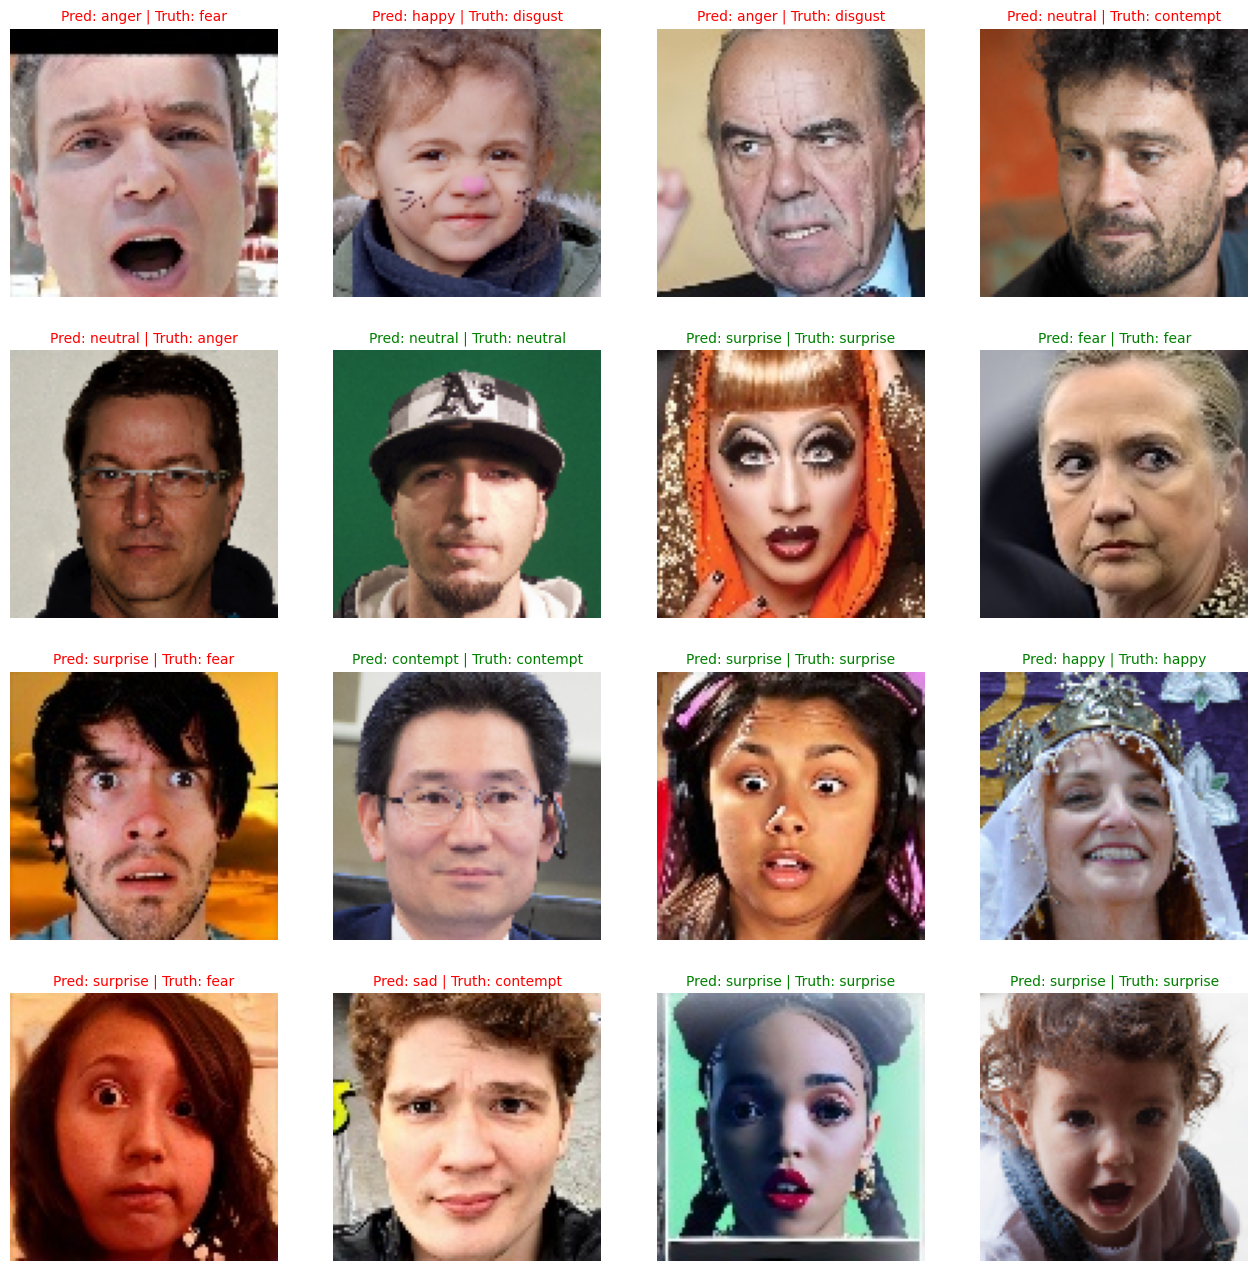

In [ ]:
# Plot those images along with the predictions
plt.figure(figsize=(16,16))
nrows, ncols = 4,4
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.cpu().permute(1,2,0) )

  # Find the prediction
  pred_label =unique_classes[pred[i]]

  # Get the truth label
  truth_label = unique_classes[test_labels[i]]

  # Change the title for the plot
  title_text = f'Pred: {pred_label} | Truth: {truth_label}'

  '''Show red text title if the prediction is incorrect
    Show green text title of the prediction is correct'''

  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c='g')
  else:
    plt.title(title_text, fontsize=10, c='r')
  plt.axis(False)
plt.show()

# 13. Evaluation uisng confusion matrix

## Import necessary libraries

In [ ]:
# Installing and importing torchmetrics
!pip install torchmetrics
from torchmetrics import ConfusionMatrix
import mlxtend
mlxtend.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

'0.22.0'

## 13.1 Confusion Matrix

In [ ]:
y_preds = []
model.eval()
with torch.inference_mode():
  for X in tqdm(X_test):
    X = X.to(device)
    # Forward pass
    y_logit = model(X.unsqueeze(0))
    # Turn prediction from logits and logits to prediction labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

    # put predictions on cpu for plotting
    y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)

  0%|          | 0/5635 [00:00<?, ?it/s]

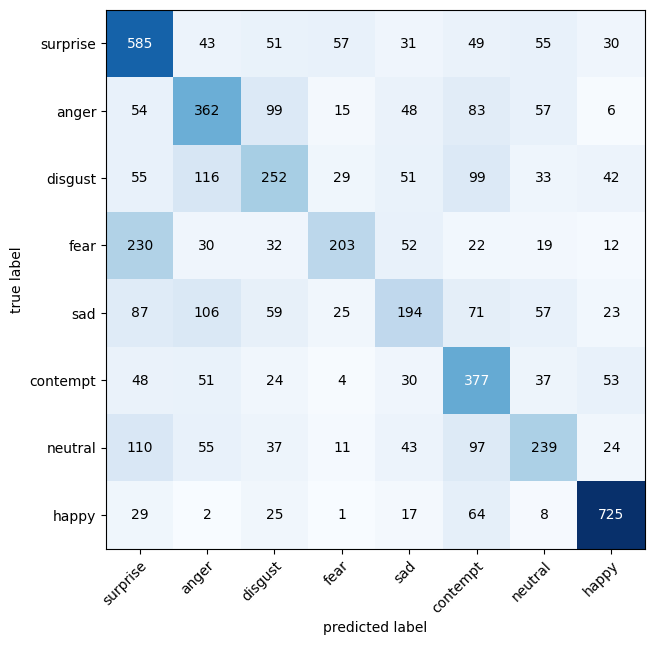

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion instance and compare pardictions to targets
confmat = ConfusionMatrix(task = 'multiclass',num_classes=len(unique_classes))
confmat_tesnor=confmat(preds=y_pred_tensor,
                       target=torch.tensor(y_test))

# Plot our confusion matrix
fig, ax = plot_confusion_matrix(

    # matplotlib only works with numpy arrays and cnnot work with tensors
    conf_mat=confmat_tesnor.numpy(),
    class_names=unique_classes,
    figsize=(10,7)
      )

# 14. Conclusion

From the above evaluation, it is evident that the TinyVGG model achived the accuracy of 40%, the model is model is trained adjusting several HYPERPARAMETERS such as adjusting the epochs, batch size of input tensors, learning rate in optimizer, etc. The one saved in this notebook gives the highest performance.